## Overview

This notebook demonstrates how to get example-based explanations for your natural language model. Such explanations can help you answer questions about why a model made a certain prediction, relating it to the points in the training data. 

The pre-requisities for this notebook are:
1. A predictive model and a way to extract a latent representation from it (usually termed embeddings). The notebook will demonstrate how this can be done for a Deep Neural Network.
2. A Google Cloud project.
3. A Google bucket to host the model and the dataset.

Once these are in place, the three main sections of the notebook are:
1. Creating and uploading a model with explanations enabled.
2. Creating an endpoint and deploying the model to it.
3. Issuing explanation request and inspecting them.

### Dataset

For this notebook, we will use the [ag_news_subset] downloaded through [TF Datasets](https://www.tensorflow.org/datasets/catalog/ag_news_subset). The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus

### Objective

In this demo we will go over:
1. Getting Example-Based explanations from Vertex Explainable AI services.
2. A use-case for exploring similar examples to understand model predictions.

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Set up your local development environment

**If you are using Colab or Google Cloud Notebooks, you can skip this step**, since your environment already meets
all the requirements to run this notebook.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install and upgrade needed packages

No additional packages are needed for this notebook, and we upgrade each relevant package.

In [1]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [2]:
PROJECT_ID = "exp-mb"
BUCKET_URI = "gs://demo-central1"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

**Run the following cell to create your Cloud Storage bucket.** If the bucket already exists, you will get an error but it wouldn't affect the rest of the tutorial. However, you might get unwanted data in this bucket.

In [3]:
# General
import time
import requests
import json
import io
import base64

# Training
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image

# Vertex AI
from google.cloud import aiplatform as vertex_ai
from google.cloud import aiplatform_v1beta1 as vertex_ai_v1beta1
from google.cloud.aiplatform_v1beta1 import ModelServiceClient, EndpointServiceClient
from google.cloud.aiplatform_v1beta1.types import io as io_pb2
from google.protobuf.struct_pb2 import Struct
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

### Set up variables

In [4]:
# Client variables
DATASET_NAME = "ag_news_subset" # Will be downloaded from https://www.tensorflow.org/datasets/catalog/ag_news_subset
ENDPOINT=f"{REGION}-aiplatform.googleapis.com"
ADMIN_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"

# Data preparation
CONCRETE_INPUT = 'numpy_inputs' # input name needed for model signature
DATA_DIR = 'data'
RAW_DIR = f'{DATA_DIR}/raw/{DATASET_NAME}'
PREPROCESSED_DIR = f'{DATA_DIR}/preprocessed/{DATASET_NAME}'

# Saved model path
PRETRAINED_MODEL_NAME = "nnlm-en-dim50"
MODEL_URI = f'{BUCKET_URI}/models/{PRETRAINED_MODEL_NAME}-{DATASET_NAME}'  # Pre-trained model will be downloaded from https://keras.io/api/applications/mobilenet/#mobilenetv2-function

### Helpers

In [5]:
def create_index_to_name_map(ds_info):
    index_to_name = {}
    num_classes = ds_info.features["label"].num_classes
    names = ds_info.features["label"].names
    for i in range(num_classes):
        index_to_name[i] = names[i]
    return index_to_name

@tf.function(input_signature=[tf.TensorSpec([None], tf.string), tf.TensorSpec(shape=[None], dtype=tf.string)])
def serving_fn(id, input_text):
    embedding = embedding_model(input_text)
    return {"id": id, "embedding": embedding}


def extract_examples_and_labels(ds, num_batches):
    data_slice = ds.take(num_batches)  # -1 uses the whole dataset
    print(num_batches)
    examples = []
    labels = []
    for example, label in data_slice:
        examples.append(example)
        labels.append(label)
    print(f"Example batch shape: {len(examples)}")
    examples = tf.concat(examples,0)
    labels = tf.concat(labels,0)
    print(f"Example batch shape: {examples.shape}")
    return examples.numpy(), labels.numpy()

def inspect_input_and_neighbors(val_example_idx, all_train_examples, val_examples, all_train_labels, val_labels, label_index_to_name, data_with_neighbors):
    TEXT_WIDTH = 200
    example = val_examples[val_example_idx].numpy()
    class_label = val_labels[val_example_idx].numpy()
    print(f"Input label: {label_index_to_name[class_label]}({class_label}). Input index: {val_example_idx}. Input example:\n{textwrap.fill(example.decode('utf-8'), width = TEXT_WIDTH)}\n")
    
    neighbor_list = data_with_neighbors[val_example_idx]['neighbors']
    num_neighbors = len(neighbor_list)
    for n in range(num_neighbors):
        neighbor = neighbor_list[n]
        neighbor_idx = int(neighbor['neighborId'])
        neighbor_example = all_train_examples[neighbor_idx].numpy()
        neighbor_dist = neighbor['neighborDistance']
        
        class_label = all_train_labels[neighbor_idx].numpy()
        print(f"Neighbor label: {label_index_to_name[class_label]}({class_label}). Neighbor index: {neighbor_idx}. "
            f"Neighbor distance: {neighbor_dist:.3f}. Neighbor example:\n {textwrap.fill(neighbor_example.decode('utf-8'), width = TEXT_WIDTH)}\n")
    print("*****************\n\n")

### Intialize Vertex AI Clients

In [6]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# client options same for all services
client_options = {"api_endpoint": API_ENDPOINT}


def create_job_client():
    client = vertex_ai_v1beta1.JobServiceClient(client_options=client_options)
    return client


def create_model_client():
    client = vertex_ai_v1beta1.ModelServiceClient(client_options=client_options)
    return client


def create_endpoint_client():
    client = vertex_ai_v1beta1.EndpointServiceClient(client_options=client_options)
    return client


def create_prediction_client():
    client = vertex_ai_v1beta1.PredictionServiceClient(client_options=client_options)
    return client


clients = {}
clients["job"] = create_job_client()
clients["model"] = create_model_client()
clients["endpoint"] = create_endpoint_client()
clients["prediction"] = create_prediction_client()

for client in clients.items():
    print(client)

('job', <google.cloud.aiplatform_v1beta1.services.job_service.client.JobServiceClient object at 0x7f1d40ca7190>)
('model', <google.cloud.aiplatform_v1beta1.services.model_service.client.ModelServiceClient object at 0x7f1d40ca7a90>)
('endpoint', <google.cloud.aiplatform_v1beta1.services.endpoint_service.client.EndpointServiceClient object at 0x7f1d40ca7fd0>)
('prediction', <google.cloud.aiplatform_v1beta1.services.prediction_service.client.PredictionServiceClient object at 0x7f1d40c5ad10>)


### Prepare Training Data

#### Download and visualize the data

In [7]:
tfds.disable_progress_bar()
train_split = "train"
test_split = "test"
split_ds, ds_info = tfds.load(
    DATASET_NAME,
    split=[train_split, test_split],
    as_supervised=True,  # Include labels\
    with_info=True,
    shuffle_files=False,
    data_dir=RAW_DIR
)
train_ds, validation_ds = split_ds
tfds.as_dataframe(ds=train_ds.take(10), ds_info=ds_info);

Dataset ag_news_subset downloaded and prepared to data/raw/ag_news_subset/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


2022-10-13 17:29:17.642153: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 17:29:17.644441: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-13 17:29:17.754356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-13 17:29:17.809112: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have 

In [8]:
print(f'Number of classes in the dataset: {ds_info.features["label"].num_classes}')
print(f'Label names: {ds_info.features["label"].names}')
# print(ds_info.features["label"].int2str(7))  # Human readable version
print(f'Number of examples in training split: {ds_info.splits[train_split].num_examples}')
print(f'Number of examples in validation split: {ds_info.splits[test_split].num_examples}')

Number of classes in the dataset: 4
Label names: ['World', 'Sports', 'Business', 'Sci/Tech']
Number of examples in training split: 120000
Number of examples in validation split: 7600


#### Batch and prefetch data



In [9]:
batch_size = 512

train_ds = train_ds.batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.batch(batch_size).prefetch(buffer_size=10)

In [10]:
label_index_to_name = create_index_to_name_map(ds_info)
print(label_index_to_name)

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


## Download a pre-trained embedding model

In [11]:
import tensorflow_hub as hub
pre_trained_embedding_model_loc = "https://tfhub.dev/google/nnlm-en-dim50/2"
pre_trained_embedding_model = hub.KerasLayer(pre_trained_embedding_model_loc, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [12]:
# Small test to inspect embeddings from the pre-trained model
for text_batch, label_batch in train_ds.take(1):
  # print(text_batch.numpy()[:5])
    embedding = pre_trained_embedding_model(text_batch)
    print(f"Embedding for the batch: {embedding}\n\n")
    print(f"Dataset shape: {embedding.shape}")

Embedding for the batch: [[ 0.13279007  0.06140124  0.1747397  ...  0.00377896  0.1353013
   0.35294548]
 [ 0.2955813   0.134404    0.09672645 ... -0.19247894 -0.08087391
  -0.32990122]
 [ 0.46365982 -0.18259482  0.07452042 ...  0.07921226 -0.1383935
   0.28922987]
 ...
 [ 0.11779197  0.22901958 -0.14160861 ... -0.11089166 -0.09499406
  -0.13324186]
 [ 0.3542565  -0.3827607   0.22900873 ... -0.02005082  0.36086604
  -0.09353664]
 [ 0.13835187 -0.07392867  0.0599376  ... -0.22547187  0.23192091
   0.23756932]]


Dataset shape: (512, 50)


2022-10-13 17:30:17.398717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
num_classes = ds_info.features["label"].num_classes
model = tf.keras.Sequential()
model.add(pre_trained_embedding_model)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()],)

epochs = 3
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, verbose=1)

Epoch 1/3
235/235 [==============================] - 95s 402ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.3395 - val_sparse_categorical_accuracy: 0.8895
Epoch 2/3
235/235 [==============================] - 94s 398ms/step - loss: 0.2663 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.2878 - val_sparse_categorical_accuracy: 0.9050
Epoch 3/3
235/235 [==============================] - 93s 397ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9357 - val_loss: 0.2818 - val_sparse_categorical_accuracy: 0.9055


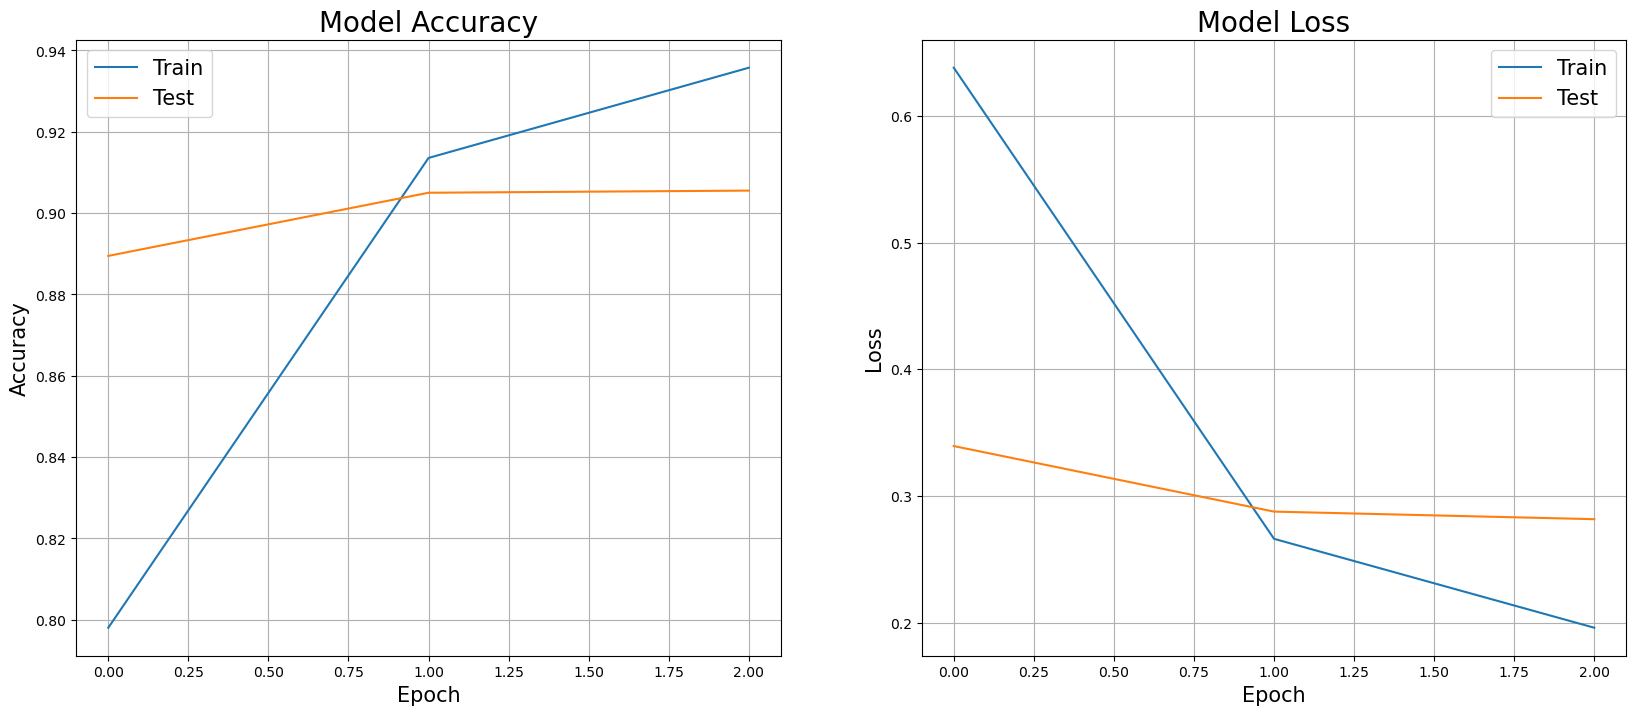

In [15]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], fontsize=15)
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=20)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train', 'Test'], fontsize=15)
plt.grid();

## Visualize performance

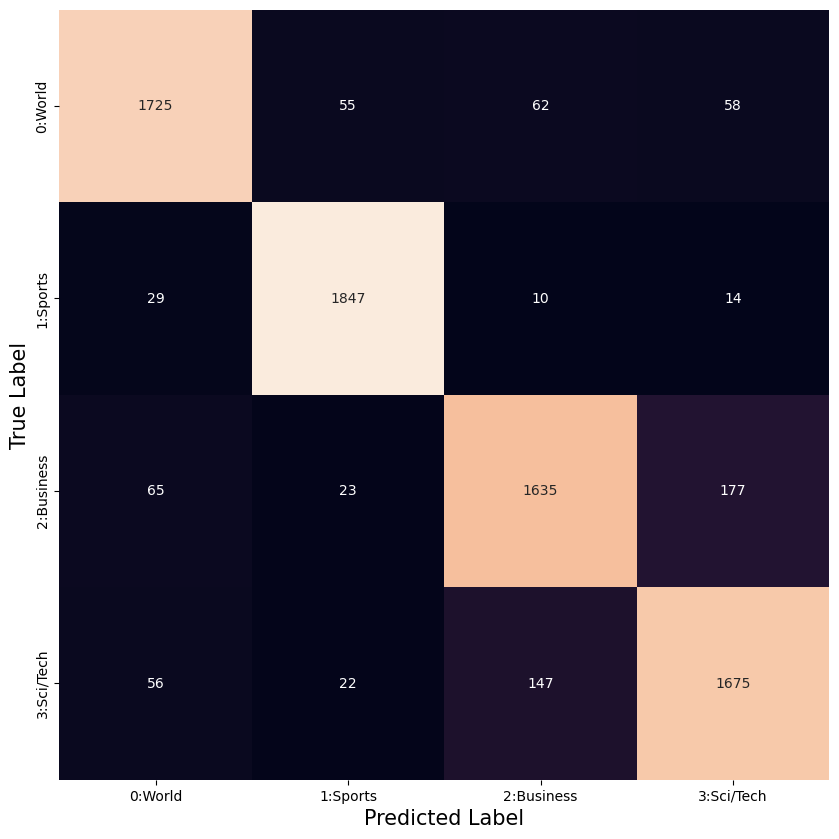

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

def display_confusion_matrix(true_labels, predicted_labels, label_index_to_name):
    num_classes = len(label_index_to_name)
    sorted_class_names = [f"{i}:{label_index_to_name[i]}" for i in range(num_classes)]
    cm = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(cm, index = sorted_class_names, columns = sorted_class_names)
    plt.figure(figsize = (10,10))
    sn.heatmap(df_cm, annot=True, cbar=False, square=True, fmt="d")
    plt.xlabel("Predicted Label", fontsize=15)
    plt.ylabel("True Label", fontsize=15)
    
validation_true_labels = np.concatenate([y for _, y in validation_ds], axis=0)
predicted_labels = np.argmax(model.predict(validation_ds), axis=1)
display_confusion_matrix(validation_true_labels, predicted_labels, label_index_to_name)

## Create embeddings. Generate model predictions.

In [17]:
embedding_model = keras.models.Model(inputs=model.input,
                                 outputs=model.get_layer('keras_layer').output)
embedding_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_input (InputLaye [(None,)]                 0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 50)                48190600  
Total params: 48,190,600
Trainable params: 48,190,600
Non-trainable params: 0
_________________________________________________________________


In [18]:
probability_model = keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
probability_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 4)                 48191484  
_________________________________________________________________
softmax (Softmax)            (None, 4)                 0         
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


In [19]:
tf.saved_model.save(embedding_model, MODEL_URI, signatures={
    'serving_default': serving_fn,
})

2022-10-13 17:37:13.088328: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://demo-central1/models/nnlm-en-dim50-ag_news_subset/assets


INFO:tensorflow:Assets written to: gs://demo-central1/models/nnlm-en-dim50-ag_news_subset/assets


## Upload the training data
The explanations are picked from this data. You can choose a smaller number of batches for a faster run but the results would be less precise.

In [20]:
import os
if not os.path.exists(PREPROCESSED_DIR):
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)

dataset_file = f'{DATASET_NAME}-train-examples.jsonl'
saved_jsonl_path = f'{PREPROCESSED_DIR}/{dataset_file}'
input_tensor_name = 'input_text'  # Must match the serving_fn definition

num_batches = -1 # uses the entire dataset
start = time.time()
all_train_examples, all_train_labels = extract_examples_and_labels(train_ds, num_batches=num_batches)
end = time.time()


-1
Example batch shape: 235
Example batch shape: (120000,)


In [21]:
def create_training_data(saved_jsonl_path, all_train_examples):
    with open(saved_jsonl_path, 'w') as f:
        for i,ex in enumerate(all_train_examples):
            json.dump({'id':str(i), input_tensor_name:str(ex)}, f)
            f.write('\n')

def upload_training_data(saved_jsonl_path, BUCKET_URI):
    ! gsutil cp {saved_jsonl_path} {BUCKET_URI}

# def benchmark_upload_training_data(saved_jsonl_path, BUCKET_URI, NUM_ITERATIONS):
#     upload_time_taken = []
#     for i in range(NUM_ITERATIONS):
#         start = time.time()
#         upload_training_data(saved_jsonl_path, BUCKET_URI)
#         end = time.time()
#         time_taken = end - start
#         upload_time_taken.append(time_taken)
#         print(f"Time taken to create and upload the training data: {time_taken:.5f} secs")
#     print(f"Time taken to upload the training data for {NUM_ITERATIONS} iterations: {upload_time_taken}")
#     return upload_time_taken
        
# start = time.time()
create_training_data(saved_jsonl_path, all_train_examples)
upload_training_data(saved_jsonl_path, BUCKET_URI)
# end = time.time()
# print(f"Time taken to create the training data: {end - start:.5f} secs\n")

# upload_time_taken = benchmark_upload_training_data(saved_jsonl_path, BUCKET_URI, NUM_ITERATIONS)

Copying file://data/preprocessed/ag_news_subset/ag_news_subset-train-examples.jsonl [Content-Type=application/octet-stream]...
\ [1 files][ 26.5 MiB/ 26.5 MiB]                                                
Operation completed over 1 objects/26.5 MiB.                                     


# Upload the model with the configuration

This step can take up to an hour to finish. Currently, there is no easy way to monitor this progresses. Exposing the run logs and job status is planned for near future.

### Create the model

#### Set Model Variables

In [22]:
DIMENSIONS = embedding_model.output.shape[1]
DATASET_FILE_PATH = f'{BUCKET_URI}/{dataset_file}'
DEPLOY_IMAGE_URI = "gcr.io/cloud-aiplatform/prediction/tf2-cpu.2-5:latest"
MODEL_NAME = f"similarity-{DATASET_NAME}-{TIMESTAMP}"
PARENT = f'projects/{PROJECT_ID}/locations/{REGION}'

#### Define serving container configuration

In [23]:
CONTAINER_CONFIG = {
    "image_uri": DEPLOY_IMAGE_URI
}

CONTAINER_SPEC = vertex_ai_v1beta1.types.ModelContainerSpec(CONTAINER_CONFIG)

#### Define Example-Based Configuration

In [24]:
NNS_CONFIG = {
              "contentsDeltaUri": "", 
              "config": {
                "dimensions": DIMENSIONS,
                "approximateNeighborsCount": 10,
                "distanceMeasureType": "SQUARED_L2_DISTANCE",
                "featureNormType": "NONE",
                "algorithmConfig": {
                "treeAhConfig": {
                    "leafNodeEmbeddingCount": 1000,
                    "leafNodesToSearchPercent": 100
                  }
                }
              }
            }

NUM_NEIGHBORS_TO_RETURN = 10

examples = vertex_ai_v1beta1.Examples(nearest_neighbor_search_config=NNS_CONFIG, 
                                      gcs_source=io_pb2.GcsSource(uris=[DATASET_FILE_PATH]), 
                                      neighbor_count=NUM_NEIGHBORS_TO_RETURN)

EXPLANATION_PARAMS_CONFIG = vertex_ai_v1beta1.types.ExplanationParameters(examples=examples)

EXPLANATION_INPUTS = {
    
          "my_input": vertex_ai_v1beta1.types.ExplanationMetadata.InputMetadata(
              {
              "input_tensor_name": input_tensor_name,
              "encoding": vertex_ai_v1beta1.types.ExplanationMetadata.InputMetadata.Encoding(1), #'IDENTITY'
              "modality": "image"
              }
          ),
          "id": vertex_ai_v1beta1.types.ExplanationMetadata.InputMetadata(
              {
              "input_tensor_name": "id",
              "encoding": vertex_ai_v1beta1.types.ExplanationMetadata.InputMetadata.Encoding(1) #'IDENTITY'
              }
          )
}

EXPLANATION_OUTPUTS = {
    "embedding" : vertex_ai_v1beta1.types.ExplanationMetadata.OutputMetadata(
        {
            "output_tensor_name": "embedding"
        }
        
    )
}

EXPLANATION_META_CONFIG = vertex_ai_v1beta1.types.ExplanationMetadata(
    inputs = EXPLANATION_INPUTS,
    outputs = EXPLANATION_OUTPUTS
)

EXPLANATION_SPEC = vertex_ai_v1beta1.types.ExplanationSpec(
    parameters=EXPLANATION_PARAMS_CONFIG,
    metadata=EXPLANATION_META_CONFIG)

In [25]:
MODEL_CONFIGURATION = {
    "display_name": MODEL_NAME,
    "artifact_uri": MODEL_URI,
    "metadata_schema_uri": "",
    "container_spec": CONTAINER_SPEC,
    "explanation_spec": EXPLANATION_SPEC,
}

### Upload the model
Sometimes it can take a while for permissions to propagate for example-based explanations. If you get an internal error, please retry once more.

In [ ]:
def upload_model(model_configuration):

    model = vertex_ai_v1beta1.Model(
        display_name=model_configuration["display_name"],
        artifact_uri=model_configuration["artifact_uri"],
        metadata_schema_uri=model_configuration["metadata_schema_uri"],
        explanation_spec=model_configuration["explanation_spec"],
        container_spec=model_configuration["container_spec"],
    )

    response = clients["model"].upload_model(parent=PARENT, model=model)
    print("Long running operation:", response.operation.name)
    upload_model_response = response.result()
    return upload_model_response


def get_model(name):
    response = clients["model"].get_model(name=name)
    print(response)

# def benchmark_upload_model(model_configuration, NUM_ITERATIONS):
#     upload_time_taken = []
#     for i in range(NUM_ITERATIONS):
#         start = time.time()
#         upload_model_response = upload_model(model_configuration)
#         end = time.time()
#         time_taken = end - start
#         upload_time_taken.append(time_taken)
#         print(f"Time taken to upload the model: {time_taken:.5f} secs")
#     print(f"Time taken to upload the model for {NUM_ITERATIONS} iterations: {upload_time_taken}")
#     return upload_time_taken, upload_model_response


# start = time.time()
# upload_model_response = upload_model(MODEL_CONFIGURATION)
# end = time.time()
# print(f"Time taken to upload the model: {end - start:.5f} secs")
# uploaded_model_id = upload_model_response.model
# uploaded_model_id = upload_model(MODEL_CONFIGURATION)


# get_model(uploaded_model_id)
upload_model_response = upload_model(MODEL_CONFIGURATION)
# upload_time_taken, upload_model_response = benchmark_upload_model(MODEL_CONFIGURATION, NUM_ITERATIONS)
uploaded_model_id = upload_model_response.model

Long running operation: projects/791305858216/locations/us-central1/models/1924686308328865792/operations/8910194085466210304


# Deploy the model


## Create endpoint for deployment

In [ ]:
ENDPOINT_NAME = f"similarity-{DATASET_NAME}-endpoint-{TIMESTAMP}"
DESCRIPTION = "An endpoint for the similarity model"
LABELS = {"status": "online"}


def create_endpoint(display_name, description, labels):
    endpoint = {
        "display_name": display_name,
        "description": description,
        "labels": labels,
    }
    response = clients["endpoint"].create_endpoint(parent=PARENT, endpoint=endpoint)
    print("Long running operation:", response.operation.name)

    result = response.result()

    return result
PARENT = f'projects/{PROJECT_ID}/locations/{REGION}'
endpoint_response = create_endpoint('new_text_news', DESCRIPTION, LABELS)
endpoint_id = endpoint_response.name
endpoint_short_id = endpoint_id.split("/")[-1]

## Deploy the uploaded model to the endpoint

In [73]:
import os
DEPLOYED_NAME = f"similarity-{DATASET_NAME}-deployed-{TIMESTAMP}"

if os.getenv("IS_TESTING_DEPLOY_GPU"):
    DEPLOY_GPU, DEPLOY_NGPU = (
        vertex_ai_v1beta1.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_DEPLOY_GPU")),
    )
else:
    DEPLOY_GPU, DEPLOY_NGPU = (None, None)
    
if os.getenv("IS_TESTING_DEPLOY_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_DEPLOY_MACHINE")
else:
    MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)
    
MIN_NODES = 1
MAX_NODES = 1

def deploy_model(
    model, deployed_model_display_name, endpoint, traffic_split={"0": 100}
):

    if DEPLOY_GPU:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_type": DEPLOY_GPU,
            "accelerator_count": DEPLOY_NGPU,
        }
    else:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_count": 0,
        }

    deployed_model = {
        "model": model,
        "display_name": deployed_model_display_name,
        "dedicated_resources": {
            "min_replica_count": MIN_NODES,
            "max_replica_count": MAX_NODES,
            "machine_spec": machine_spec,
        },
        "enable_container_logging": False,
    }

    response = clients["endpoint"].deploy_model(
        endpoint=endpoint, deployed_model=deployed_model, traffic_split=traffic_split
    )

    print("Long running operation:", response.operation.name)
    result = response.result()
#     print("result")
    deployed_model = result.deployed_model

    return deployed_model.id

# def benchmark_deploy_model(model, deployed_model_display_name, endpoint, NUM_ITERATIONS):
#     time_taken_list = []
#     for i in range(NUM_ITERATIONS):
#         start = time.time()
#         deployed_model_id = deploy_model(model, deployed_model_display_name, endpoint)
#         end = time.time()
#         time_taken = end - start
#         time_taken_list.append(time_taken)
#         print(f"Time taken to deploy the model: {time_taken:.5f} secs")
#     print(f"Time taken to deploy the model for {NUM_ITERATIONS} iterations: {time_taken_list}")
#     return time_taken_list, deployed_model_id

# start = time.time()
uploaded_model_id = result.model
# upload_model_id = 'projects/'+PROJECT_ID+'/locations/'+REGION+'/models/'+uploaded_model_id
deployed_model_id = deploy_model(upload_model_id, DEPLOYED_NAME, endpoint_id)
# end = time.time()
# print(f"Time taken to deploy model: {end - start:.5f} secs")
# time_taken_list, deployed_model_id = benchmark_deploy_model(uploaded_model_id, DEPLOYED_NAME, endpoint_id, NUM_ITERATIONS)

Deploy machine type n1-standard-4
Long running operation: projects/791305858216/locations/us-central1/endpoints/2742837308603498496/operations/2956813610082369536
Time taken to deploy model: 574.44398 secs


# Request example-based explanations

## Prepare the validation data
We will issue queries for this data. For the purpuse of the demo, we will choose a small subset of the full validation dataset.

In [213]:
input_tensor_name = 'input_text' 
val_dataset_file = f'{DATASET_NAME}-val-examples.jsonl'
saved_val_jsonl_path = f'{PREPROCESSED_DIR}/{val_dataset_file}'

num_batches = 1
start = time.time()
val_examples, val_labels = extract_examples_and_labels(validation_ds, num_batches=num_batches)
end = time.time()
print(f"Time taken to process validation data: {end - start:.5f} secs")
val_ex=val_examples[:30]
with open(saved_val_jsonl_path, 'w') as f:
    for i,ex in enumerate(val_ex):
        json.dump({'id':str(i), input_tensor_name:str(ex)}, f)
        f.write('\n')
    

1
Example batch shape: 1
Example batch shape: (512,)
Time taken to process validation data: 0.03566 secs


In [218]:
val_data = []
with open(saved_val_jsonl_path) as f:
  for line in f:
    val_data.append(json.loads(line))
print(f'{len(val_data)} data points.')

30 data points.


## Run prediction requests

In [173]:
# from google.cloud import aiplatform
def explain_example(formatted_data, endpoint, parameters, deployed_model_id):

    # The format of each instance should conform to the deployed model's prediction input schema.
    instances_list = formatted_data
    instances = [
        json_format.ParseDict(instance, Value()) for instance in instances_list
    ]
    # endpoint = aiplatform.Endpoint(endpoint_id)
    # response = endpoint.explain(instances=instances, parameters=parameters,deployed_model_id=deployed_model_id)
    response = clients["prediction"].explain(
        endpoint=endpoint,
        instances=instances,
        parameters=parameters,
        # deployed_model_id=deployed_model_id,
    )
    return response
response = explain_example(val_data, endpoint_id, None, deployed_model_id)

In [217]:
len(val_data)

20

In [219]:

def get_explanations(val_data, NUM_VAL_DATA, BATCH_SIZE, endpoint_id, deployed_model_id):
    dataset_size = len(val_data)
    all_neighbors = []
    time_taken_list = []
    examples_processed_each_iter = []
    if NUM_VAL_DATA > dataset_size:
        print(f"Requesting {NUM_VAL_DATA} explanations while the dataset is only {dataset_size}")
    for data_idx in range(0, NUM_VAL_DATA, BATCH_SIZE):
        end_idx = min(data_idx + BATCH_SIZE, NUM_VAL_DATA)
        formatted_data = val_data[data_idx:end_idx]
        start = time.time()
        response = explain_example(formatted_data, endpoint_id, None, deployed_model_id)
        end = time.time()
        time_taken = end - start
        time_taken_list.append(time_taken)
        examples_processed_each_iter.append(len(formatted_data))
        print(f"Time taken to explain {len(formatted_data)} examples: {time_taken:.5f} secs")
        all_neighbors = (
            all_neighbors + json_format.MessageToDict(response._pb)["explanations"]
        )
    print(f"\nProcessed: {len(all_neighbors)} examples in batches of size {BATCH_SIZE}. Iterations: {len(time_taken_list)}")
    print(f"Time taken to explain examples for {len(time_taken_list)} iterations: {time_taken_list}")
    print(f"Examples processed in {len(time_taken_list)} iterations: {examples_processed_each_iter}")
    return all_neighbors, time_taken_list, examples_processed_each_iter

BATCH_SIZE = (
    8  # The request payload has a size limit so we need to subbatch our request
)
NUM_VAL_DATA = 30

start = time.time()
all_neighbors, time_taken_list, examples_processed_each_iter = get_explanations(val_data, NUM_VAL_DATA, BATCH_SIZE, endpoint_id, deployed_model_id)
end = time.time()
print(f"Time taken to generate explanations: {end - start:.5f} secs")

Time taken to explain 8 examples: 0.26765 secs
Time taken to explain 8 examples: 0.25737 secs
Time taken to explain 8 examples: 0.20978 secs
Time taken to explain 6 examples: 0.20255 secs

Processed: 30 examples in batches of size 8. Iterations: 4
Time taken to explain examples for 4 iterations: [0.26764535903930664, 0.2573704719543457, 0.2097795009613037, 0.20255184173583984]
Examples processed in 4 iterations: [8, 8, 8, 6]
Time taken to generate explanations: 0.94636 secs


In [220]:
# Save input ids and the corresponding neighbors
data_with_neighbors = []
input_data_list = val_data[:NUM_VAL_DATA]

for i, input_data in enumerate(input_data_list):
    neighbor_dict = all_neighbors[i]
    neighbor_dict["input"] = input_data["id"]
    data_with_neighbors.append(neighbor_dict)

DEBUG = False
if DEBUG:
    val_idx = 0
    print(data_with_neighbors[val_idx])
    print(data_with_neighbors[val_idx]["neighbors"])
    print(data_with_neighbors[val_idx]["input"])
    print(len(data_with_neighbors[val_idx]["neighbors"]))

## Inspect explanations

In [222]:
val_example_indices = [29] # examples to inspect
for val_example_idx in val_example_indices:
    if val_example_idx > NUM_VAL_DATA - 1:
        print(f'\n\n****Data index {val_example_idx} does not exist in the requested explanations***\n\n')
        continue
    inspect_input_and_neighbors(val_example_idx, all_train_examples, val_examples, all_train_labels, val_labels, label_index_to_name, data_with_neighbors)

Input label: World(0). Input index: 29. Input example:
AFP - Microsoft said it will join with India's second-largest software firm, Infosys Technologies, to provide software and consulting to manufacturing, banking and automobile companies.

Neighbor label: Sci/Tech(3). Neighbor index: 90937. Neighbor distance: 0.964. Neighbor example:
 AP - Software giant Microsoft Corp. signed software partnerships Monday with India's leading outsourcing firms, Infosys Technologies Ltd. and Wipro Ltd., and stepped up plans to hire more programmers
in India.

Neighbor label: Sci/Tech(3). Neighbor index: 100302. Neighbor distance: 1.158. Neighbor example:
  BERKELEY, Calif. (Reuters) - The United States has nothing  to fear from rapidly growing technology markets in China and  India, Bill Gates, chairman and chief software architect of  Microsoft Corp.
&lt;A HREF="http://www.reuters.co.uk/financeQuoteLookup.jhtml?ticker=MSFT.O qtype=sym infotype=info qcat=news"&gt;MSFT.O&lt;/A&gt; said on Friday.

Neig

## Further exploration
If you want to continue exploring, here are some ideas:
1.   Isolate test points where the model is making mistakes (cat mislabed as bird), and visualize the example-based explanations to see if you can find any common patterns.
2.   If through this analysis, you find your training data is lacking in some representative cases (overhead images of cats), you can try adding such images to your dataset to see if that improves model performance.
3.   [Fine-tune](https://keras.io/guides/transfer_learning/) the lower layers of the model to see if you can improve the quality of example-based explanations by enabling the model to learn a better latent representation.



## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete the endpoint
endpoint_list = vertex_ai.Endpoint.list(filter=f'display_name="{ENDPOINT_NAME}"')
for e in endpoint_list:
  e.delete(force=True)

In [ ]:
# Delete model
model_list = vertex_ai.Model.list(filter=f'display_name="{MODEL_NAME}"')
for m in model_list:
  m.delete()

In [ ]:
# Delete Cloud Storage objects that were created
delete_bucket = False

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}